In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from state_cleaner import *
import datetime
import csv
from scipy import stats as st

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
os.chdir('../..')
os.chdir('CovidMobile')
os.getcwd()

'/Users/samismalling/Documents/mobility-report-data-extractor-master/CovidMobile'

In [3]:
df = pd.read_csv('data/compiled_2020-04-21.csv')

In [4]:
df['peaks'] = df.groupby(['FIPS'])['cases'].transform(max)

In [5]:
df.rename(columns={'state_x':'state','county_x':'county'},inplace=True)

In [6]:
df['post_soe'] = np.where(df['date']>=df['soe'],1,0)
df['post_sah'] = np.where(df['date']>=df['sah'],1,0)

In [7]:
def t_test(pop,div,metric):
    data = pop.dropna(subset=[metric])
    s1 = data[data[div]==1][metric].copy()
    s2 = data[data[div]==0][metric].copy()
    print('What happend at {}?'.format(metric))
    print(data.groupby([div])[metric].describe())
    print("\n T-Test Results = {} (t-stat,2 sided p-values)".format(st.ttest_ind(s1,s2)))

In [8]:
for i in ['retail','food_drugs','park','transit','work','homes']:
    t_test(df,'post_soe',i)
    t_test(df,'post_sah',i)

What happend at retail?
            count       mean        std    min   25%   50%   75%    max
post_soe                                                               
0         58686.0   8.300770  11.339559  -85.0   2.0   8.0  14.0  153.0
1         74764.0 -24.533893  21.916760 -100.0 -40.0 -29.0  -9.0  226.0

 T-Test Results = Ttest_indResult(statistic=-329.9193674842295, pvalue=0.0) (t-stat,2 sided p-values)
What happend at retail?
             count       mean        std    min   25%   50%   75%    max
post_sah                                                                
0         108743.0  -3.157932  20.766688 -100.0 -17.0   3.0  11.0  226.0
1          24707.0 -40.624519  12.316418 -100.0 -48.0 -40.0 -33.0   60.0

 T-Test Results = Ttest_indResult(statistic=-272.89177542159325, pvalue=0.0) (t-stat,2 sided p-values)
What happend at food_drugs?
            count      mean        std   min   25%  50%   75%    max
post_soe                                                            

In [8]:
prez = pd.read_csv("data/countypres_2000-2016.csv")

In [9]:
prez.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
0,2000,Alabama,AL,Autauga,1001.0,President,Al Gore,democrat,4942.0,17208,20191203
1,2000,Alabama,AL,Autauga,1001.0,President,George W. Bush,republican,11993.0,17208,20191203
2,2000,Alabama,AL,Autauga,1001.0,President,Ralph Nader,green,160.0,17208,20191203
3,2000,Alabama,AL,Autauga,1001.0,President,Other,NaN,113.0,17208,20191203
4,2000,Alabama,AL,Baldwin,1003.0,President,Al Gore,democrat,13997.0,56480,20191203


In [10]:
prez['vote_share']= prez['candidatevotes'] / prez['totalvotes']
prez['vote_share'].describe()

count    50120.000000
mean         0.314603
std          0.264512
min          0.000000
25%          0.022464
50%          0.327248
75%          0.539318
max          0.960334
Name: vote_share, dtype: float64

In [11]:
#who got the most votes that year in that county
prez['max'] = prez.groupby(['FIPS','year'])['candidatevotes'].transform(max)

#adding in the share of republican votes for each county
prez_win = prez[prez['max']==prez['candidatevotes']].copy()
prez_win = pd.concat([prez_win.reset_index(),prez[prez['party']=='republican']['vote_share'].rename('vote_share_rep').reset_index()],axis=1)

In [12]:
prez_win.head()

,index,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version,vote_share,max,index,vote_share_rep
0,1.0,2000.0,Alabama,AL,Autauga,1001.0,President,George W. Bush,republican,11993.0,17208.0,20191203.0,0.696943,11993.0,1,0.696943
1,5.0,2000.0,Alabama,AL,Baldwin,1003.0,President,George W. Bush,republican,40872.0,56480.0,20191203.0,0.723654,40872.0,5,0.723654
2,8.0,2000.0,Alabama,AL,Barbour,1005.0,President,Al Gore,democrat,5188.0,10395.0,20191203.0,0.499086,5188.0,9,0.490236
3,13.0,2000.0,Alabama,AL,Bibb,1007.0,President,George W. Bush,republican,4273.0,7101.0,20191203.0,0.601746,4273.0,13,0.601746
4,17.0,2000.0,Alabama,AL,Blount,1009.0,President,George W. Bush,republican,12667.0,17973.0,20191203.0,0.704779,12667.0,17,0.704779


In [13]:
prez_win.sort_values(by=['FIPS','year'],inplace=True)
for i in list(range(1,5,1)):
    shifted =prez_win.groupby(['FIPS'])['candidate','party','candidatevotes','totalvotes','vote_share_rep'].shift(i)
    prez_win = prez_win.join(shifted.rename(columns=lambda x: x+"_{}".format(i)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
prez_win = prez_win[prez_win['party_4'].notnull()].copy() 

In [15]:
prez_win.columns

Index(['index', 'year', 'state', 'state_po', 'county', 'FIPS', 'office',
       'candidate', 'party', 'candidatevotes', 'totalvotes', 'version',
       'vote_share', 'max', 'index', 'vote_share_rep', 'candidate_1',
       'party_1', 'candidatevotes_1', 'totalvotes_1', 'vote_share_rep_1',
       'candidate_2', 'party_2', 'candidatevotes_2', 'totalvotes_2',
       'vote_share_rep_2', 'candidate_3', 'party_3', 'candidatevotes_3',
       'totalvotes_3', 'vote_share_rep_3', 'candidate_4', 'party_4',
       'candidatevotes_4', 'totalvotes_4', 'vote_share_rep_4'],
      dtype='object')

In [16]:
conditions = [
    (prez_win['party']=='republican')&((prez_win['party_1']=='democrat')|(prez_win['party_2']=='democrat')),
    (prez_win['party']=='republican')&(prez_win['party_1']=='republican')&(prez_win['party_2']=='republican'),
    (prez_win['party']=='democrat')&(prez_win['party_1']=='democrat')&(prez_win['party_2']=='democrat'),
    (prez_win['party']=='democrat')&((prez_win['party_1']=='republican')|(prez_win['party_2']=='republican')),
]
vals =['flip_trump','stay_trump','stay_hill','flip_hill']


In [17]:
prez_win['results'] =  np.select(conditions, vals, default='miss')

In [18]:
df_tog = df.merge(prez_win,on=['FIPS'],how='left')

In [19]:
df_tog = df_tog[df_tog['geo']=='county'].copy()
df_tog.geo.value_counts()

county    152210
Name: geo, dtype: int64

In [28]:
df_tog.head()

,country_region_code,country_region,state_x,county_x,date,retail,food_drugs,park,transit,work,...,vote_share_rep_3,candidate_4,party_4,candidatevotes_4,totalvotes_4,vote_share_rep_4,results,partisan_cat,dow,vote_share_rep_avg
0,US,United States,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,5,NaN
1,US,United States,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,5,NaN
2,US,United States,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,6,NaN
3,US,United States,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,6,NaN
4,US,United States,NaN,NaN,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,NaN


In [29]:
#Now working through the USDA data to get population data:
usda_full = pd.read_excel('./data/food_env_atlas_usda.xls', sheet_name = None)
sheet_names = usda_full.keys()
for sheet_name in usda_full.keys():
    print(sheet_name)

Read_Me
Variable List
Supplemental Data - County
Supplemental Data - State
ACCESS
STORES
RESTAURANTS
ASSISTANCE
INSECURITY
PRICES_TAXES
LOCAL
HEALTH
SOCIOECONOMIC


In [ ]:
usda_pop = usda_full['Supplemental Data - County']

# Models

In [20]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels as sm
from statsmodels.iolib.summary2 import summary_col

Y(i,t,s) = X(i,t,s) + B(i) + S(s) +T(t)

## Data Transformations

In [21]:
df_tog['date'] =pd.to_datetime(df_tog['date'],errors='coerce')
df_tog.results = df_tog.results.astype('category')
df_tog["partisan_cat"] = df_tog["results"].cat.codes
df_tog['dow'] = df_tog['date'].dt.dayofweek
df_tog['vote_share_rep_avg'] = (df_tog['vote_share_rep'] + df_tog['vote_share_rep_1'] + df_tog['vote_share_rep_2']) / 3

df_tog.head()

,country_region_code,country_region,state_x,county_x,date,retail,food_drugs,park,transit,work,...,vote_share_rep_3,candidate_4,party_4,candidatevotes_4,totalvotes_4,vote_share_rep_4,results,partisan_cat,dow,vote_share_rep_avg
0,US,United States,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,5,NaN
1,US,United States,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,5,NaN
2,US,United States,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,6,NaN
3,US,United States,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,6,NaN
4,US,United States,NaN,NaN,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,NaN


In [22]:
#Creating dummy variables of day and state
dow_dumms = pd.get_dummies(df_tog.dow)
dow = dow_dumms.columns.values
state_dumms = pd.get_dummies(df_tog.state_abb_x)
states = state_dumms.columns.values
day_dumms = pd.get_dummies(df_tog['date'].dt.date)
print(len(day_dumms.columns))
day_dumms.columns = ['day' + str(i) for i in list(range(0,len(day_dumms.columns)))]
days = day_dumms.columns.values

57


In [23]:
#Adding in other RHS variables (model 1)
df_fin = pd.concat([df_tog,pd.get_dummies(df_tog['party']),state_dumms,dow_dumms,day_dumms],axis=1)
df_fin['ln_pop'] = df_fin['POP_ESTIMATE_2018'].apply(np.log)
df_fin['ln_income'] = df_fin['Median_Household_Income_2018'].apply(np.log)
df_fin['ln_employed'] = df_fin['Employed_2018'].apply(np.log)
df_fin['ln_unemployed'] = df_fin['Unemployed_2018'].apply(np.log)
df_fin['obs'] = 1
df_fin = df_fin.dropna(subset= ['party'])
df_fin = df_fin[(df_fin['results']=='stay_trump')|(df_fin['results']=='stay_hill')].copy()
print(df_fin.shape)
df_fin['consecutive_days'] = df_fin.groupby(['FIPS'])['obs'].transform(sum)
df_fin['nomiss'] = np.where( df_fin[['retail','food_drugs','transit','work','homes']].isnull().any(axis=1),0,1)
df_fin['consecutive_days_nomiss'] = df_fin.groupby(['FIPS','nomiss'])['obs'].transform(sum)

(129824, 258)


In [27]:
#Adding in other RHS variables (model 2)
df_fin = pd.concat([df_tog,pd.get_dummies(df_tog['party']),state_dumms,dow_dumms,day_dumms],axis=1)


0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
           ...  
155112    6967.0
155113    6967.0
155114    6967.0
155115    6967.0
155116    6967.0
Name: POP_ESTIMATE_2018, Length: 152210, dtype: float64

## Setting up regression loops

In [24]:
conditions = [
    df_fin['obs']==1,
    (df_fin['obs']==1)&(df_fin['consecutive_days']==57),
    (df_fin['nomiss']==1),
    (df_fin['nomiss']==1)&(df_fin['consecutive_days_nomiss']==57)
]
vals =['all','all_days','no_miss','no_miss_days']
for i,x in list(zip(conditions,vals)):
    df_fin[x]=np.where(i,1,0)



In [25]:
lhs = ['retail','food_drugs','transit','work','homes']
rhs = ['republican','vote_share_rep_avg']
controls = ['ln_pop','ln_income','ln_employed','ln_unemployed','post_soe','post_sah'] + list(days) + list(states)
sample = ['all','all_days','no_miss','no_miss_days']

## Running Regressions

In [72]:
res = []
models = []
for x in rhs:
    for y in lhs:
        for s in sample:
            sam = df_fin[df_fin[s]==1]
            X = [x] + controls 
            strng = '{} ~ '.format(y) + ' + '.join([str(i) for i in X])
            mod = smf.ols(strng,data=sam)
            print(s,y,x)
            r = mod.fit(cov_type='HC1', return_type='dataframe')
            res.extend([r])
            title = 'Sample={}\nLHS={}\nRHS={}'.format(s,y,x)
            models.extend([title])
results = summary_col(res,stars=True,float_format='%0.2f',
                  model_names=models,
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'R2':lambda x: "{:.2f}".format(x.rsquared),
                            'R2adj':lambda x: "{:.2f}".format(x.rsquared_adj),
                            'F-pval':lambda x: "{:.2f}".format(int(x.f_pvalue))})
pd.DataFrame(results.tables[0]).to_csv('models/first_run.csv')

all retail republican
all_days retail republican
no_miss retail republican
no_miss_days retail republican
all food_drugs republican
all_days food_drugs republican
no_miss food_drugs republican
no_miss_days food_drugs republican
all transit republican
all_days transit republican
no_miss transit republican
no_miss_days transit republican
all work republican
all_days work republican
no_miss work republican
no_miss_days work republican
all homes republican
all_days homes republican
no_miss homes republican
no_miss_days homes republican
all retail vote_share_rep_avg
all_days retail vote_share_rep_avg
no_miss retail vote_share_rep_avg
no_miss_days retail vote_share_rep_avg
all food_drugs vote_share_rep_avg
all_days food_drugs vote_share_rep_avg
no_miss food_drugs vote_share_rep_avg
no_miss_days food_drugs vote_share_rep_avg
all transit vote_share_rep_avg
all_days transit vote_share_rep_avg
no_miss transit vote_share_rep_avg
no_miss_days transit vote_share_rep_avg
all work vote_share_rep_avg


C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 114, but rank is 112
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 114, but rank is 112
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 114, but rank is 112
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 114, but rank is 111
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Noah\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarni

# Graphs

In [20]:
grp_1 = pd.melt(df_tog, id_vars=['FIPS', 'date'], value_vars=['retail','food_drugs','park','transit','work','homes']) 
grp_1.dropna(inplace=True)
grp_1[['FIPS', 'date']].drop_duplicates().shape

(152039, 2)

In [21]:
grp_2 = pd.melt(df_tog, id_vars=['FIPS', 'date','candidate'], value_vars=['retail','food_drugs','park','transit','work','homes']) 
grp_2.dropna(inplace=True)
grp_2[['FIPS', 'date']].drop_duplicates().shape

(151492, 2)

In [22]:
grp_3 = pd.melt(df_tog, id_vars=['FIPS', 'date','results'], value_vars=['retail','food_drugs','park','transit','work','homes']) 
grp_3.dropna(inplace=True)
grp_3[['FIPS', 'date']].drop_duplicates().shape

(151492, 2)

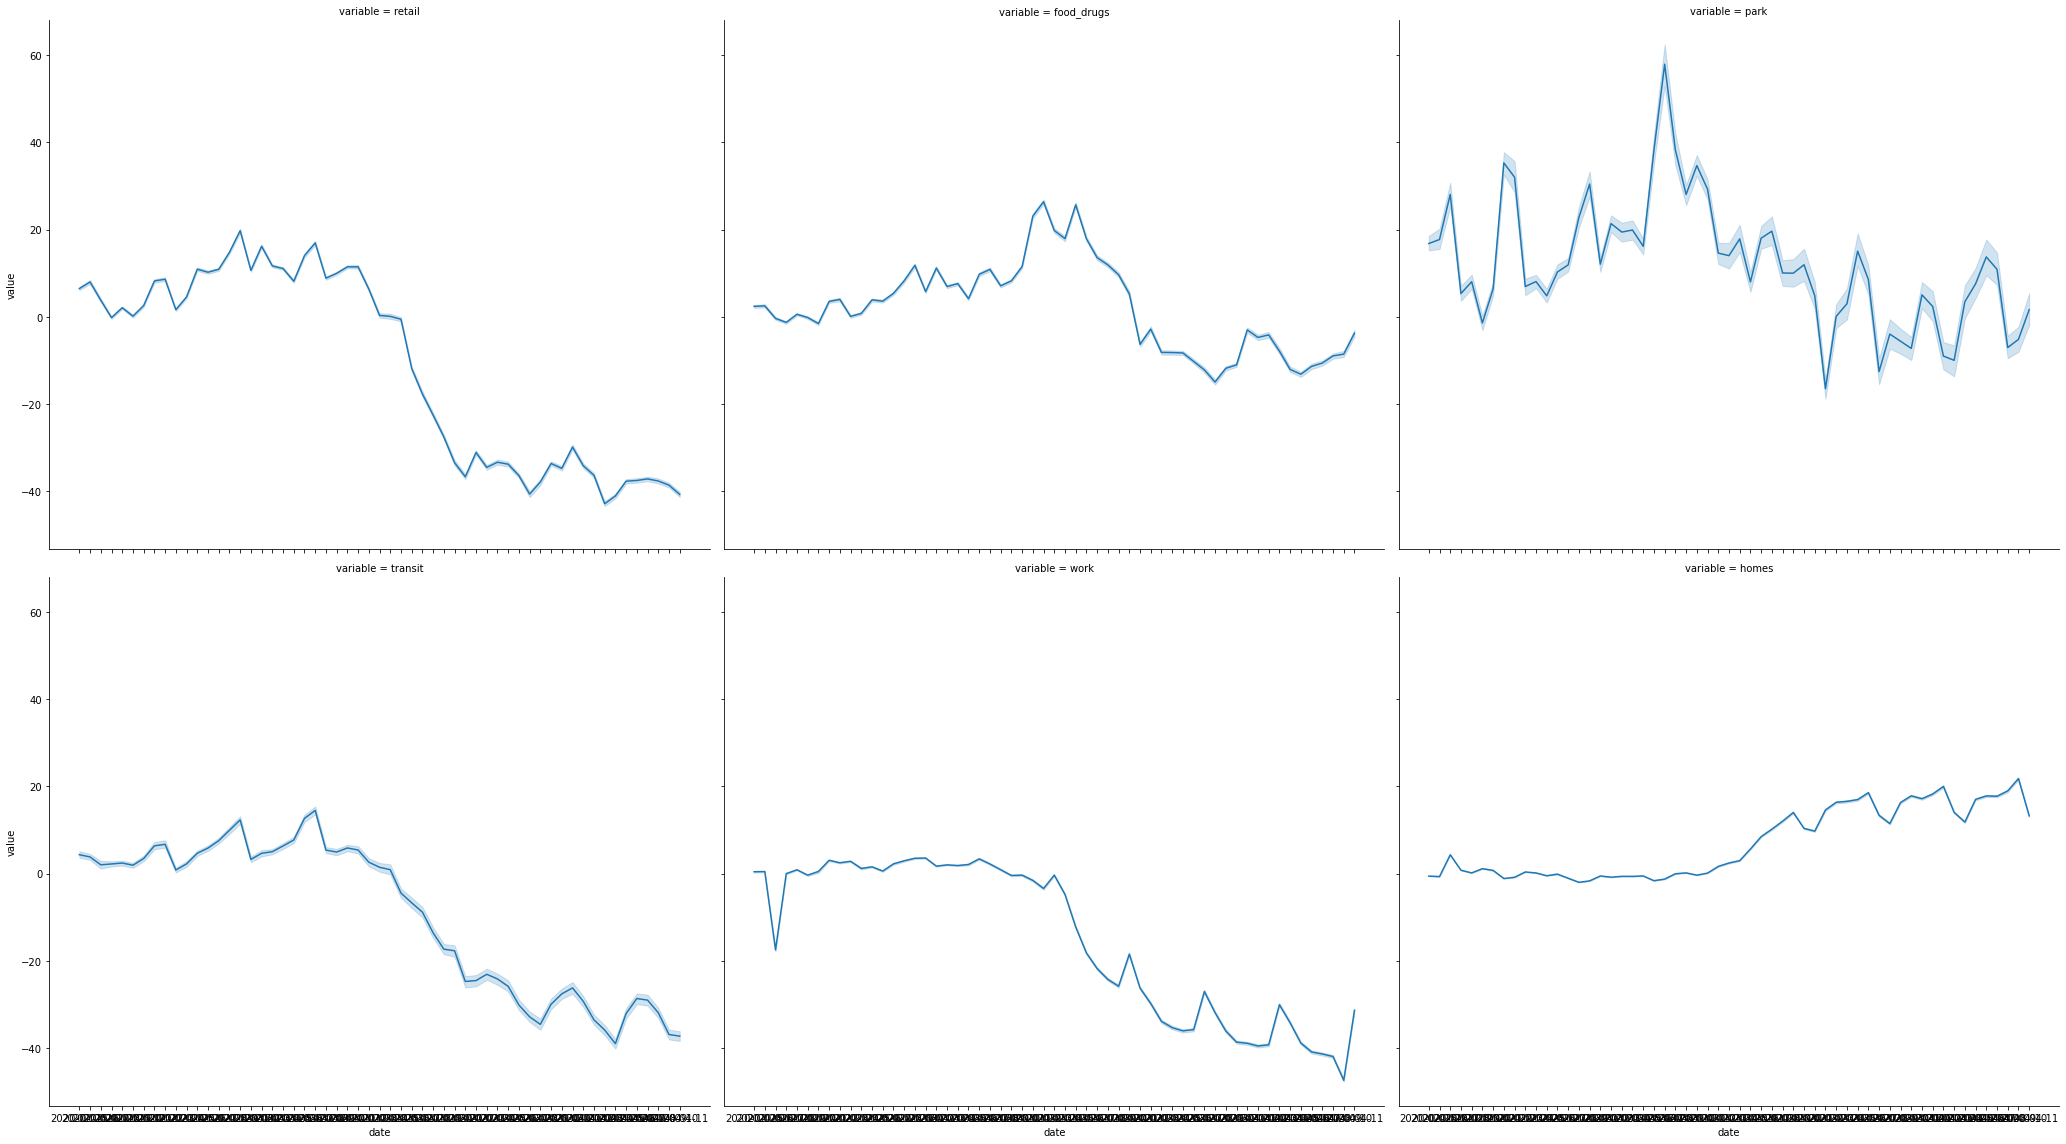

In [23]:
g = sns.relplot(x="date", y="value",
                 col="variable",
                 kind="line", data=grp_1,height=8, aspect=1.2,col_wrap=3)

plt.savefig('graphs/mobility_by_county_overall.png')

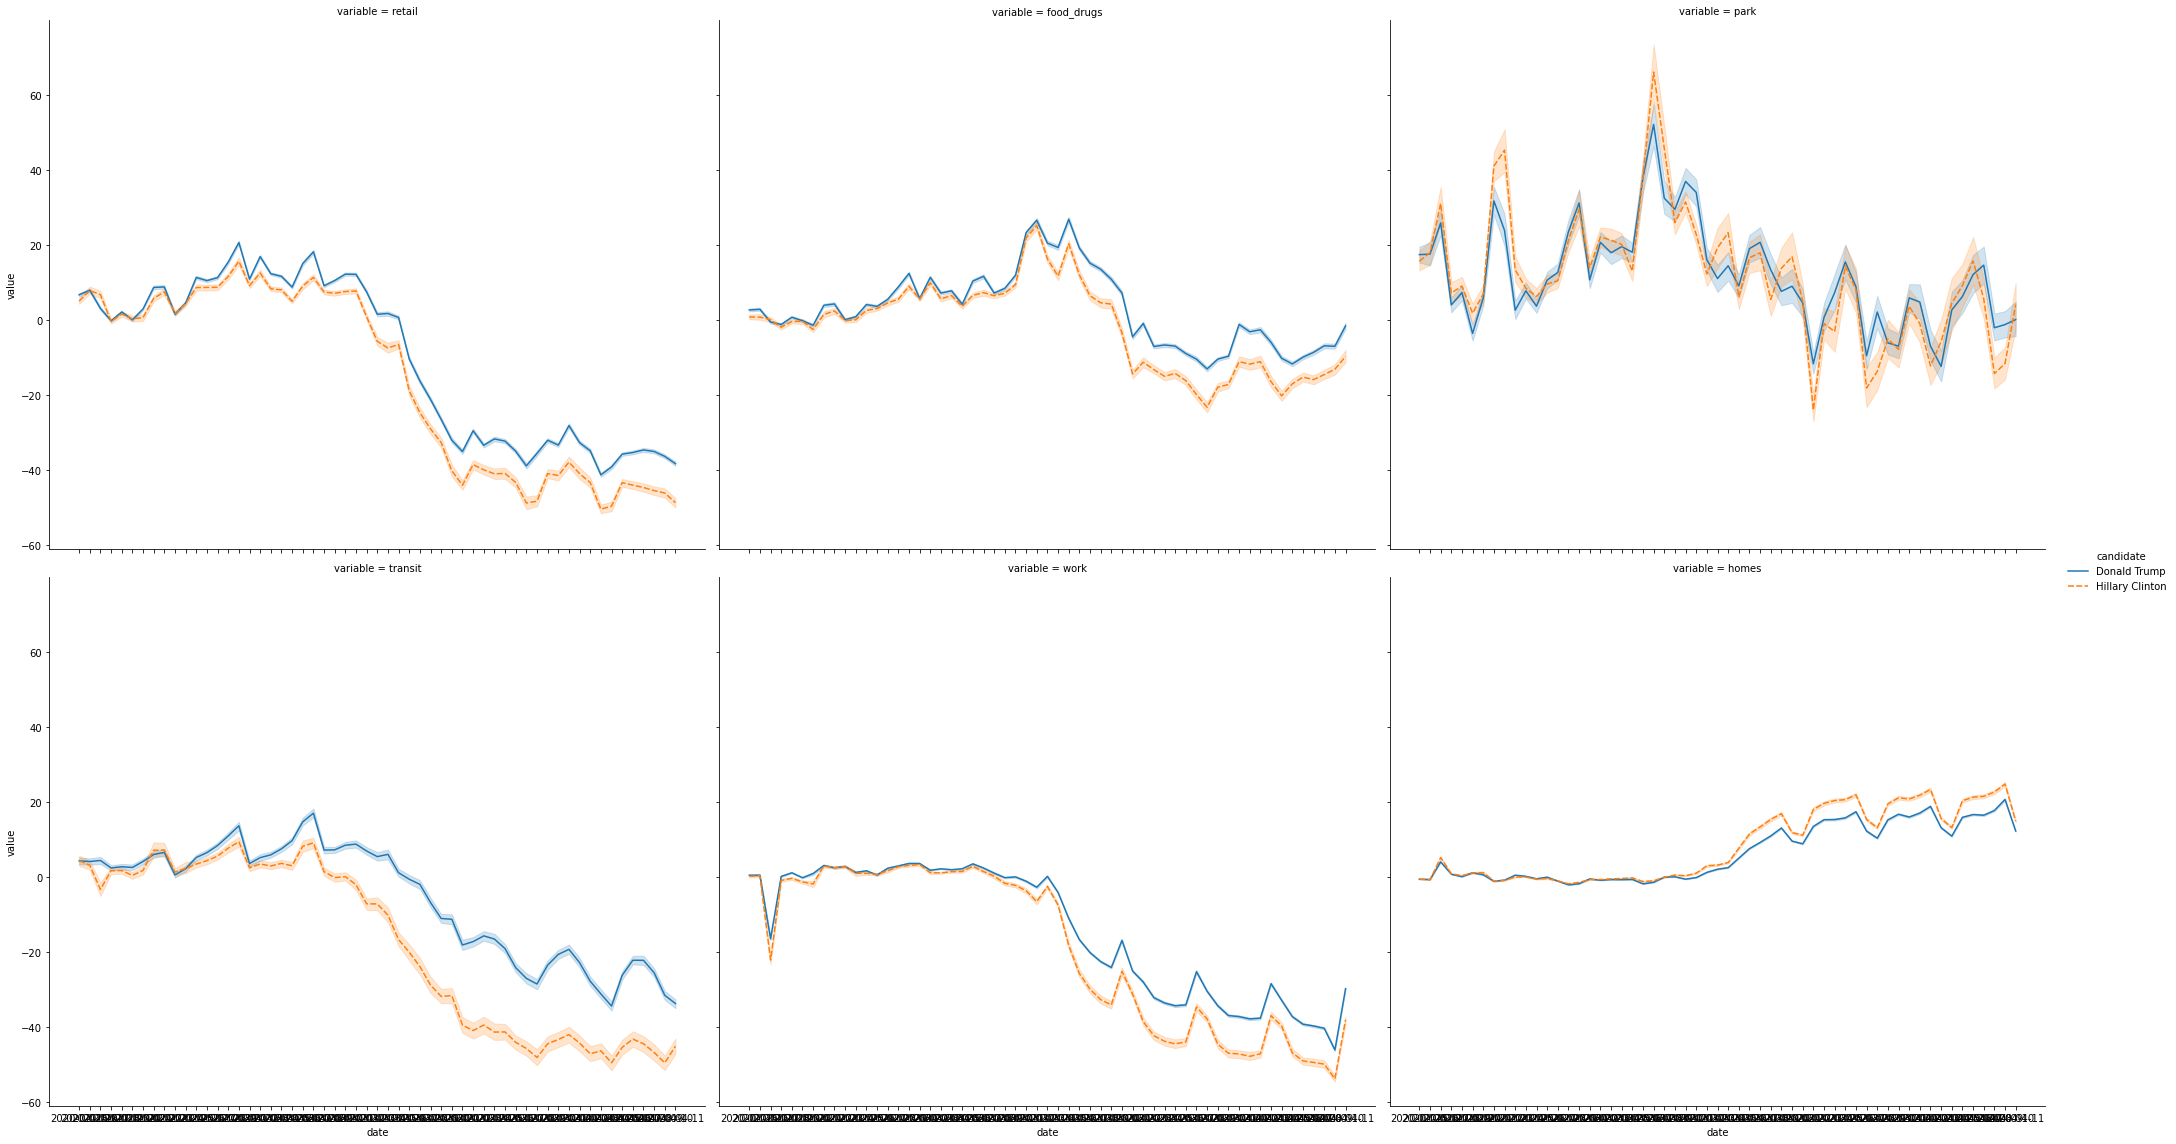

In [24]:
g = sns.relplot(x="date", y="value",
                 col="variable", hue="candidate", style="candidate",
                 kind="line", data=grp_2,height=8, aspect=1.2,col_wrap=3)

plt.savefig('graphs/mobility_by_county_voting_2016.png')

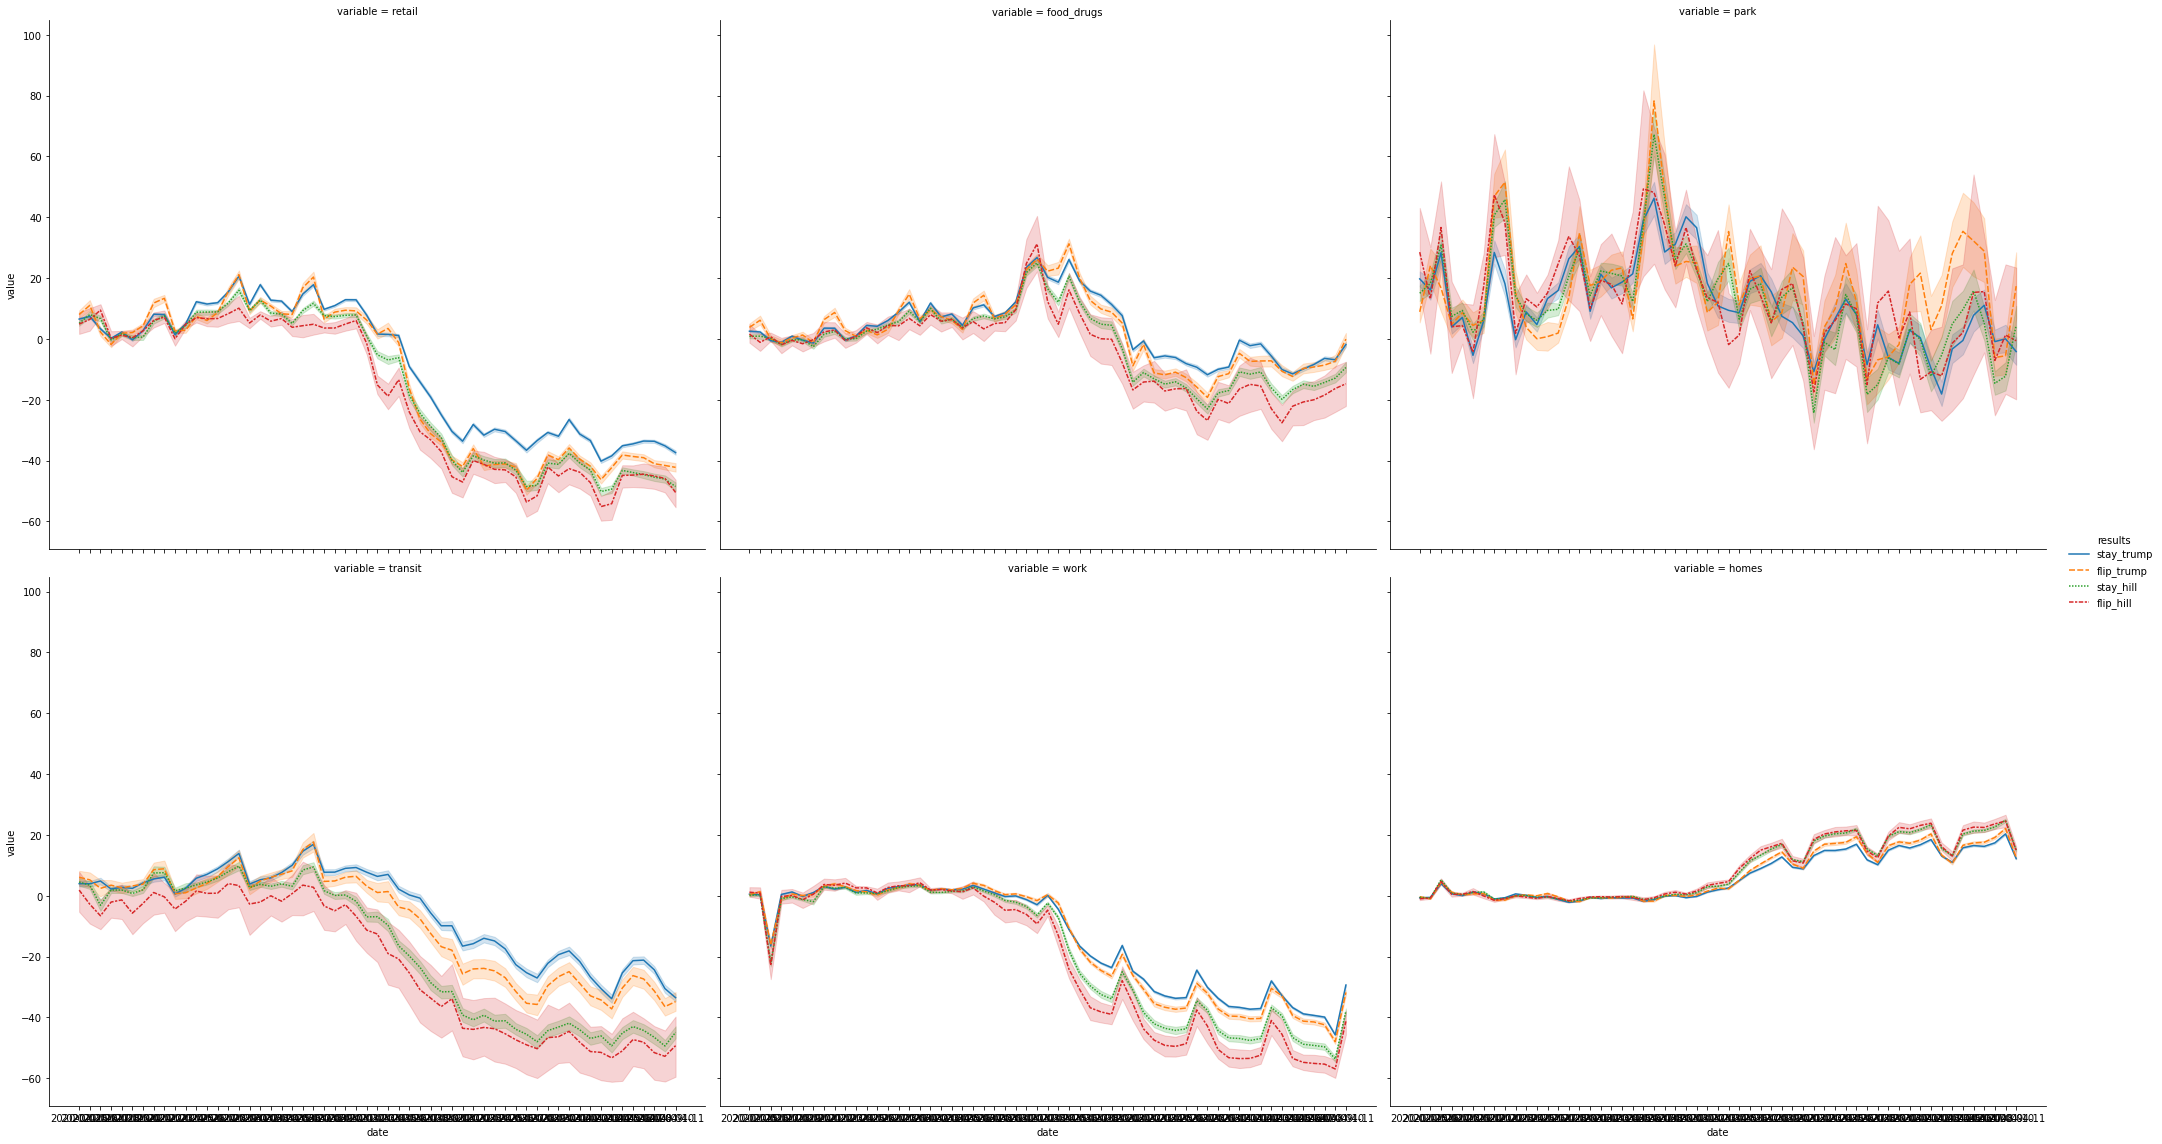

In [25]:
g = sns.relplot(x="date", y="value",
                 col="variable", hue="results", style="results",
                 kind="line", data=grp_3,height=8, aspect=1.2,col_wrap=3)

plt.savefig('graphs/mobility_by_county_voting_history.png')